In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [269]:
df=pd.read_csv(r"C:\Users\yusuf\Desktop\Workspace url\Sales_.csv")

In [270]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.Order_date = df.Order_date.astype('datetime64')

In [271]:
df = df[['Customer_ID','Order_ID','Order_date','Quantity','Price']]
df['Revenue'] = df.Quantity * df.Price

In [272]:
RFM =df.groupby('Customer_ID').agg({'Order_ID':'count','Revenue':'sum','Order_date':lambda x :(df.Order_date.max()-x.max()).days})
RFM.rename(columns={'Order_ID':'Frequency','Revenue':'Monetary','Order_date':'Recency'},inplace=True)

In [273]:
quantiles = RFM.quantile(q=[0.25,0.5,0.75]).to_dict()

In [274]:
def condition_r(x,col='Frequency'):             ## Create a condition function to convert values in 'F' and 'M' columns
    if x < RFM[col].quantile(0.25):              ## The lower the recency value is the better for the business.
        return 4
    elif x < RFM[col].quantile(0.5):
        return 3
    elif x < RFM[col].quantile(0.75):
        return 2
    else:
        return 1

In [275]:
def condition_f_m(x,col='Frequency'):    ## Create a condition function to convert values in 'F' and 'M' columns
    if x < RFM[col].quantile(0.25):       ## The higher the monetary and frequency is the better for the business.
        return 1
    elif x < RFM[col].quantile(0.5):
        return 2
    elif x < RFM[col].quantile(0.75):
        return 3
    else:
        return 4

In [276]:
RFM['F_label']=RFM.Frequency.apply(lambda x : condition_f_m(x,col='Frequency'))   ## Apply the conversion functions to the columns
RFM['M_label']=RFM.Monetary.apply(lambda x : condition_f_m(x,col='Monetary'))
RFM['R_label']=RFM.Recency.apply(lambda x : condition_r(x,col='Recency'))

In [277]:
RFM.head(3)

,Frequency,Monetary,Recency,F_label,M_label,R_label
Customer_ID,,,,,,
20000,6,184.5,235,1,1,1
20001,13,951.0,21,4,4,4
20002,7,341.2,63,1,1,2


Newly created labels show the ranking for each row. 4 is the best number. The best row is the one with three '4' values. Such row represents a customer who makes purchase frequently, who has spent high amount of money and who purchased very recently.

In [278]:
RFM['Score'] = RFM[['F_label','M_label','R_label']].sum(axis=1)
RFM = RFM.sort_values('Score',ascending=False)

In [279]:
RFM['Segment'] = pd.qcut(RFM.Score,4,['Diamond','Gold','Silver','Bronze'][::-1])
RFM

,Frequency,Monetary,Recency,F_label,M_label,R_label,Score,Segment
Customer_ID,,,,,,,,
20114,17,949.8,19,4,4,4,12,Diamond
20044,13,832.6,0,4,4,4,12,Diamond
20133,14,1116.6,3,4,4,4,12,Diamond
20130,13,770.2,9,4,4,4,12,Diamond
20231,13,888.2,17,4,4,4,12,Diamond
...,...,...,...,...,...,...,...,...
20200,7,134.7,188,1,1,1,3,Bronze
20254,5,260.2,100,1,1,1,3,Bronze
20218,5,204.7,183,1,1,1,3,Bronze


In [280]:
RFM.Segment.value_counts()

Silver     102
Bronze      75
Gold        71
Diamond     52
Name: Segment, dtype: int64

## RFM Exploratory Data Analysis

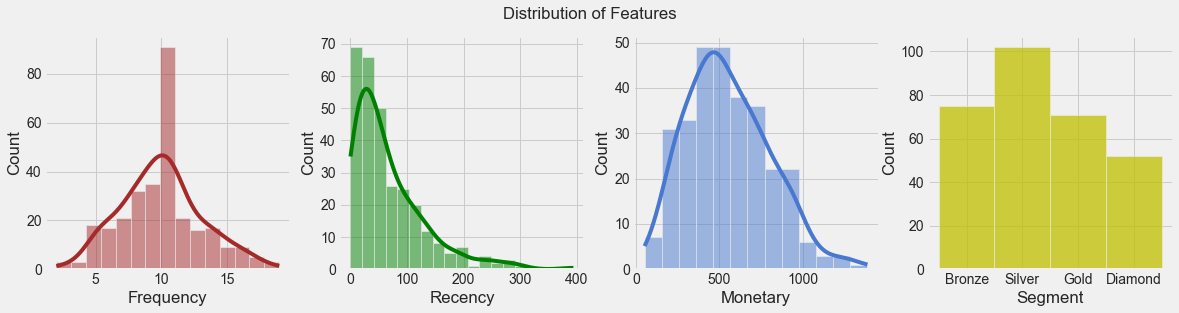

In [281]:
fig,axes = plt.subplots(1,4, figsize=(18,4))
plt.suptitle('Distribution of Features')
sns.histplot(RFM.Frequency,ax = axes[0],color='brown',kde=True)
sns.histplot(RFM.Recency,ax = axes[1],color='green',kde=True)
sns.histplot(RFM.Monetary,ax = axes[2],kde=True)
sns.histplot(RFM.Segment,ax = axes[3],color='y')
plt.show()

## Correlation Between The Features

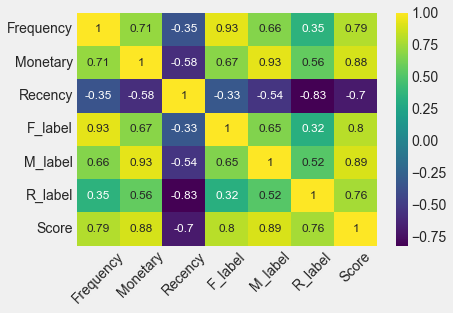

In [282]:
cor = RFM.corr()
sns.heatmap(cor,annot=True, cmap= 'viridis',annot_kws={'size':12})
plt.xticks(rotation = 45)
plt.show()

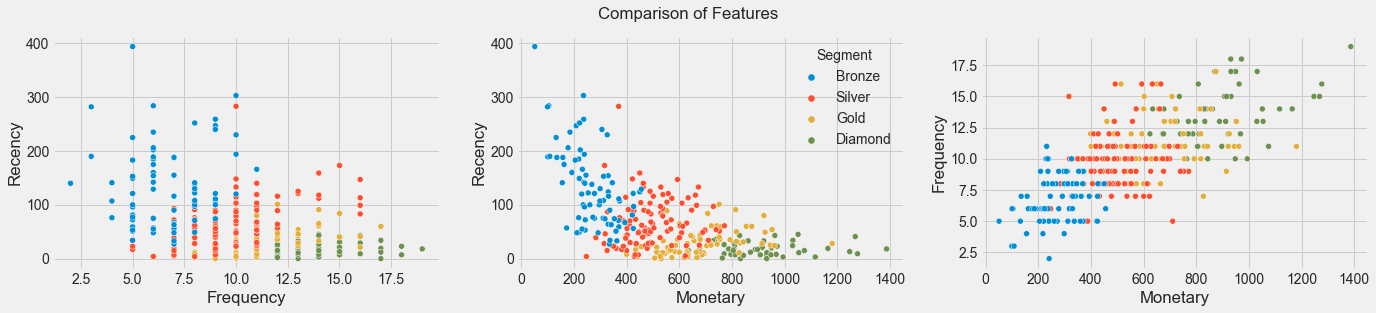

In [283]:
fig,axes = plt.subplots(1,3,figsize=(21,4))
plt.suptitle('Comparison of Features')
sns.scatterplot(RFM.Frequency,RFM.Recency,hue=RFM.Segment,ax=axes[0],legend=False)
sns.scatterplot(RFM.Monetary,RFM.Recency,hue=RFM.Segment,ax=axes[1])
sns.scatterplot(RFM.Monetary,RFM.Frequency,hue=RFM.Segment,ax=axes[2],legend=False)
plt.show()

Here, these scatterplots show the correlation between the columns;
 **Frequency** is positively correlated with **Monetary**, negatively correlated with **Recency**,
 **Recency** is negatively correlated with **Monetary** and **Frequency**,
 **Monetary** is positively correlated with **Frequency**, negatively correlated with **Recency**.

## Business Strategy According to the Findings

As a result of the analysis, there are 4 main customer segments; Diamond,Gold,Silver,Bronze. General profile of a customer is as following:
**Diamond** -  This segment is the most valuable among all. Losing these customers would severely hit the profitability of the business. The behaviours of these customers show that they are happy with the quality, price and other conditions. Therefore, customers from this segment should be provided with more than ordinary promotions to boost the relationship even more. An example could be giving early access for new productions, involving them into the decision-making processes of the business.

**Gold** - This segment is also happy with the business operations, however there are still some subtle improvements to make. Some may show relatively low frequency, some may have a low purchase volume. It is crucial to detect the improvable part and create solutions. For example; If the frequency is low, making analysis of substitute products on the market would be a good idea, because low frequency generally is an indicator of that the customer buys the products of other brands from time to time.

**Silver** - Silver customers requires a lot of attention to successfully convert them into Gold or Diamond. Renewed price lists, promotions, different accessibility options could be tried for strengthen the relationship. Example; if the problem is high recency, it is an amazing way to remind the products of the business by reaching out to the customers with new deals and promotions so that get back to the prior routine.

**Bronze** - Bronze customers are the hardest segment to regain. Retention costs are high for this segment. They require more effort, more money and more time to be retained. It is not always profitable to spend resources for this segment. Only if the business aims to get more market share and profitability is not the priority, this segment should be targeted. Low cost activities should be chosen to detect what caused them to avoid the products.